# A/B Testing
## Analyzing an A/B Test of Two Web Page Presentations vs various demographic/user categories

### About the Dataset

#### A/B Test

The A/B test was performed for an online shopping webpage. The A-Version is the current webpage version, used by the control group, and B-Version is the proposed webpage version, used by the treatment group.

**CONVERSION:** In this A/B test, conversion is the purchase of items by the user. The test also keeps track of purchase amounts, allowing us to evaluate the success of B-Version in terms of revenue.

**Users:** The test is performed in 7 different countries. All users are registered. From registration we have user information on their location and age (mandatory registration fields). User sex is an optional registration field, and therefore remains unspecified for some users.

#### Dataset Description – A/B Testing Data

This dataset contains 294,478 rows and 12 columns, capturing user behavior, demographics, and experimental conditions for an A/B testing experiment. It can be used to analyze differences between control and treatment groups, user engagement, and conversion/purchase behavior. 



**Columns Overview**

- **user_id** (string): Unique identifier for each user.
- **timestamp** (datetime): The date and time of the user’s recorded session.
- **group** (string): A/B test group assignment:
	control → users exposed to the old version.
	treatment → users exposed to the new version.
- **landing_page** (string): The webpage shown to the user (old_page or new_page).
- **converted** (int: 0/1): Indicates whether the user converted (1 = yes, 0 = no).
- **age** (integer): User’s age in years.
- **sex** (string): Sex of the user (Male, Female, Unspecified).
- **location** (string): User’s location (country: e.g., Pakistan, UK, US).
- **session_duration** (float): Length of session in minutes.
- **pages_visited** (integer): Number of pages visited during the session.
- **device_type** (string): Device used to access the platform (Mobile, Tablet, Desktop).
- **purchase_amount** (float): Amount of money ($) spent during the session (0 if no purchase).

*! We are also provided with the Cost Per Incremental Conversion (CPIC) per country = the estimated dollar amount required in investment to achive a unit increament of conversion rate. 

#### Data Quality
- No missing values across all columns. 
- Data types are appropriate (numeric, categorical, datetime). 
- Large enough sample size (≈ 294k rows) for reliable statistical analysis. **However** if the dataset subgroups are used for analysis, their sample size can be small and may not lead to statistically significant results. 

### Potential Uses
- Compare conversion rates between control and treatment groups. 
- Analyze user behavior by device type, sex, and location. 
- Explore whether session duration, age, or pages visited influence conversion. 
- Study purchase patterns and revenue impact of the new landing page.

## This Project's scope

The company has commissioned an analysis of the experimental data with the mandate to deliver an investment strategy that maximizes revenue and growth potential across all markets. The company has a number of promotional actions it can use to increase user base (bring in more registrations) or encourage more spending from already registered users. This analysis therefore focuses on:


1. Examine the overall success of website's B-Version to proposes whether it's ready for immediate rollout or not, and in which markets 
2. If B-Version is ready for rollout, conduct a ROI analysis on appropriate user segments to propose targeted investment strategies


  

# Strategic Investment Data Analysis

This analysis delivers data-driven investment recommendations derived from an extensive A/B test evaluation. By pivoting from traditional behavioral metrics to a revenue-centric framework, this report identifies high-yield opportunities that maximize revenue-increment impact.

Based on the IDA/EDA analysis conclusions I focus directly on revenue-based analysis. The main objectives directing this analysis are:

**Objectives:**
1. **Confirm global success:** Confirm the global economic success of Version B by validating revenue uplift alongside conversion gains.
2. **Define ROI-driven KPIs:** Establish metrics for optimal revenue growth.
3. **Market Prioritization:** Tier countries based on investment opportunity.
4. **Granular Recommendations:** Target specific user segments for localized growth.

In [1]:
## packages imports
import pandas as pd
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import norm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math

In [2]:
## user functions

# create a function to quickly perform basic, visual data inspection#
def basic_data_inspection(data):
    print('Inspect first 5 rows (and headers if applicable):')
    display(data.head())
    print()
    print('Show data info:')
    display(data.info())
    print()
    print('Check if any missing values exist (per column):')
    display(data.isna().sum())
    print()
    print('Show basic stats for numeric variales')
    display(data.describe())


def calculate_revenue_status(row):
    """
    Business logic for classifying revenue uplift and market status.
    Designed to be used with DataFrame.apply(axis=1).
    """
    control = row['revenue_control']
    treat = row['revenue_treatment']
    
    if control > 0 and treat == 0:
        return pd.Series([-100.0, 'Total attrition'])
    elif control == 0 and treat > 0:
        return pd.Series([100.0, 'New Opportunity'])
    elif control == 0 and treat == 0:
        return pd.Series([0.0, 'Inactive'])
    elif control > 0 and treat > 0:
        return pd.Series([((treat - control) / control) * 100, 'Active Market'])
    
    return pd.Series([-np.inf, 'error'])
        
def analyze_ab_segments(df, dimensions):
    """
    Complete A/B Pipeline: Aggregates raw data and runs statistical tests.
    
    Parameters:
    - df: The raw pandas DataFrame
    - dimensions: List of strings (e.g., ['location', 'device_type'])
    """
    # 1. Internal Aggregation (The "agg_df" logic)
    # We filter out 'Unspecified' internally to keep the input data clean
    # agg = df[df['sex'] != 'Unspecified'].groupby(dimensions + ['group'], observed=True).agg( #simplify this. remove filtering from here
    agg = df.groupby(dimensions + ['group'], observed=True).agg( 
        n_users=('converted', 'size'),
        conversions=('converted', 'sum'),
        revenue=('purchase_amount', 'sum')
    ).unstack()
    
    # 2. Flatten columns
    agg.columns = [f'{metric}_{grp}' for metric, grp in agg.columns]
    agg = agg.reset_index()
    
    # 3. Statistical and Revenue Inference
    # Vectorized math for speed (no loop needed for these!)
    agg['CR_Control'] = agg['conversions_control'] / agg['n_users_control']
    agg['CR_Treatment'] = agg['conversions_treatment'] / agg['n_users_treatment']
    agg['lift_bps'] = (agg['CR_Treatment'] - agg['CR_Control'])*10000
    
    rev_c = agg['revenue_control']
    rev_t = agg['revenue_treatment']
    agg['incremental_revenue'] = rev_t-rev_c
    
    agg[['revenue_uplift_percent', 'market_status']] = agg.apply(calculate_revenue_status, axis=1)
    # agg['rev_uplift_pct'] = rev_uplift_pct_flagged[0]
    # agg['rev_uplift_flag'] = rev_uplift_pct_flagged[1]

    
    # 4. Z-Test (We still loop here because proportions_ztest isn't natively vectorized)
    z_stats = []
    p_vals = []
    total_users = [] # will be needed for segment opportunity map
    
    for _, row in agg.iterrows():
        n_obs = [row['n_users_control'], row['n_users_treatment']]
        n_succ = [row['conversions_control'], row['conversions_treatment']]
        try:
            stat, pval = proportions_ztest(n_succ, n_obs, alternative='two-sided')
        except:
            stat, pval = np.nan, np.nan
        z_stats.append(stat)
        p_vals.append(pval)
        total_users.append(np.sum(n_obs))
        
    agg['Z_Stat'] = z_stats
    agg['P_Value'] = p_vals
    agg['Treatment_Wins'] = agg['lift_bps'] > 0
    agg['Significant'] = agg['P_Value'] < 0.05
    agg['total_users'] = total_users

    #clean up the agg_df
    agg.drop(['n_users_control', 'n_users_treatment','conversions_control','conversions_treatment'], axis=1, inplace=True)
    agg = agg.reset_index()
    return agg

def mybarplot(plot_data, x, y, hue, order, ax=None, title='plot_title', 
              x_label='x_label', y_label='y_label', palette='viridis', 
              errorbar=None, legend=False):
    
    # 1. Use default ax if not provided
    if ax is None:
        ax = plt.gca()
    
    # 2. Draw the plot
    sns.barplot(
        data=plot_data, x=x, y=y, hue=hue, ax=ax,
        order=order, palette=palette, errorbar=errorbar, legend=legend
    )
    
    # 3. Annotate
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', label_type='edge', padding=3, weight='bold') 
    
    # 4. Styling (Using AX methods, not PLT)
    y_max = plot_data[y].max()
    ax.set_ylim(top=y_max * 1.2) # Extra room for labels

    ax.set_title(title, fontsize=14, weight='bold', pad=15)
    ax.set_ylabel(y_label, fontsize=12, weight='bold')
    ax.set_xlabel(x_label, fontsize=12, weight='bold')
    
    # Tick Label Customization
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='x', rotation=45) 
    
    # # Bold the tick labels
    # for label in ax.get_xticklabels() + ax.get_yticklabels():
    #     label.set_fontweight('bold')
    return ax # Allows further customization outside the function


def plot_segment_opportunity_map(df):
    # 1. Setup Plot Style
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # 2. Setup Colorbar Logic (Incremental Revenue)
    norm = plt.Normalize(df['incremental_revenue'].min(), df['incremental_revenue'].max())
    sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
    sm.set_array([])

    # 3. Create the Scatter Plot 
    # IMPORTANT: legend=False disables the messy automatic legend
    sns.scatterplot(
        data=df,
        x='revenue_control',
        y='revenue_uplift_percent',
        size='total_users',
        hue='incremental_revenue',
        palette='RdYlGn',
        sizes=(100, 1000), 
        alpha=0.7,
        edgecolor='black',
        legend=False, 
        ax=ax
    )

    # 4. Add Vertical/Horizontal "Baseline" lines
    l3 = ax.axhline(0, color='red', linestyle='-', linewidth=2, alpha=0.5, label='Zero Uplift')
    l2 = ax.axhline(df['revenue_uplift_percent'].median(), color='purple', linestyle='--', linewidth=2, alpha=0.5, label='Median Uplift')
    l1 = ax.axvline(df['revenue_control'].median(), color='blue', linestyle=':', lw=2, alpha=0.4, label='Median Revenue')
    # l4 = ax.axvline(df['revenue_control'].quantile(0.75), color='red', linestyle=':', lw=2, alpha=0.4, label='75th perc. Revenue')


    # 5. Annotate the bubbles 
    y_min, y_max = df['revenue_uplift_percent'].min(), df['revenue_uplift_percent'].max()
    y_range = y_max - y_min
    base_offset = y_range * 0.03
    for i in range(df.shape[0]):
        # don't annotate some bubbles that are cluttered
        #Generalize in function and create user input parameters
        if (df.revenue_uplift_percent.iloc[i] > 81) or (df.revenue_control.iloc[i] > df.revenue_control.median()):
        # if (df.revenue_uplift_percent.iloc[i] < df.revenue_uplift_percent.median()) and (df.revenue_control.iloc[i] > df.revenue_control.median()):
            radius_offset = (np.sqrt(df.total_users.iloc[i]) / np.sqrt(df.total_users.max())) * base_offset
            ax.text(x=df.revenue_control.iloc[i], y=df.revenue_uplift_percent.iloc[i] + radius_offset,
                     s=df.user_profile.iloc[i], fontsize=9, ha='center', va='bottom', alpha=0.8, fontweight='bold')

    # 6. CREATE MANUAL LEGEND (Proxy Artists)
    # 6.1 Colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.01)
    cbar.set_label('Incremental Revenue ($)', fontsize=12, labelpad=10)

    # 6.2 Manual Size Legend (4 bubbles)
    handles = [l1, l2, l3]#, l4] # Start with benchmark lines
    labels = ['Median Uplift', 'Median Revenue', 'Zero Uplift']#, '75th perc. Revenue']
    
    # Create 4 representative sizes
    size_ticks = np.linspace(df['total_users'].min(), df['total_users'].max(), 4)
    for s in size_ticks:
        # We create a 'proxy' scatter point (empty list means it won't show on plot)
        # s_plot maps the data value to the (100, 1000) visual range
        s_plot = np.interp(s, [df['total_users'].min(), df['total_users'].max()], [100, 1000])
        proxy = ax.scatter([], [], s=s_plot, color='white', edgecolor='black', alpha=0.6)
        handles.append(proxy)
        labels.append(f'{int(s):,}') # Format with commas for readability

    # 6.3 Build the final legend
    ax.legend(handles, labels, 
              title="Benchmarks & Total Users", 
              loc="upper left", 
              bbox_to_anchor=(1.15, 1), 
              frameon=True, 
              borderpad=1.5, # space between the legend border and the content
              labelspacing=1.0, # space between labels (eg circles)
              handletextpad=2.0,  # space between the circle and the text label
              handleheight=2.2    # Gives "room" to accommodate the height of larger bubbles
             
             ) 

    # 7. Final Styling
    # This styling is specific for Pakistan. Can be generalized
    ax.set_title('Segment Opportunity Map: Growth vs. Scale (Pakistan)', fontsize=14, pad=15, weight='bold')
    ax.set_xlabel('Baseline (Control Group) Segment Revenue ($)', fontsize=12, weight='bold')
    ax.set_ylabel('Revenue Uplift (%)', fontsize=12, weight='bold')
    #Can we set the locations of Q labels? Maintain option for manual positioning
    ax.text(8000, 250, 'Q1',fontsize=20, weight='bold', color='red')
    ax.text(2000, 250, 'Q2',fontsize=20, weight='bold', color='red')
    ax.text(8000,  25, 'Q3',fontsize=20, weight='bold', color='red')
    ax.text(2000,  25, 'Q4',fontsize=20, weight='bold', color='red')
    plt.subplots_adjust(right=0.75) # Adjusting to fit the side legend/cbar
    
    return plt


# 1) Read and Transform data

In [3]:
#load data#
data_df = pd.read_csv('AB_Test_Data.csv')

# define your plot output directory for savefig
# paths are set to expect plots_dir
# Not setting plot_dir will cause errors, unless you change the paths details
plots_dir='YOUR_PATH'

* I follow the EDA results to transform the data

In [4]:
# Drop 'timestamp', 'landing_page', 'session_duration', 'pages_visited'.

data_df.drop(['timestamp', 'landing_page', 'session_duration', 'pages_visited'], axis=1, inplace=True)

# drop users with unspecified sex
data_df=data_df[data_df['sex']!='Unspecified']

# Create the age_group and age_group_short columns #

# We create 4 age segments:
# 18-24 (Young Adult) 
# 25-40 (Adult) 
# 41-55 (Mid-Life)
# 56-65 (Mature)

bins = [17, 24, 40, 55, 65]
labels_full = ['18-24(Young Adult)', '25-40(Adult)', '41-55(Mid-Life)', '56-65(Mature)']
labels_short = ['Youth', 'Adult', 'Mid', 'Mature']

# Create the age_group column with full label (better for tables/legends)
data_df['age_group'] = pd.cut(data_df['age'], bins=bins, labels=labels_full)

# Create another age_group_short column with sort label (better for plots)
data_df['age_group_short'] = pd.cut(data_df['age'], bins=bins, labels=labels_short)
# 
# Check the distribution to ensure significance
# print(data_df['age_group'].value_counts())
# data_df

In [5]:
# Create the sex_short columns, with single-letter sex code (better for some plots) #
data_df['sex_short'] = data_df['sex'].str[:1]
# Create the device_type_short columns, with three-letter sex code (better for some plots) #
data_df['device_type_short'] = data_df['device_type'].str[:3]
# Create the new column "user_profile" - we use the short names 
data_df['user_profile']=data_df['sex_short'].str.cat(data_df['age_group_short'].astype(str), sep='/').str.cat(data_df['device_type_short'], sep='/')


# 2) Examination of (relative) revenue uplift to confirm global success

* While we have seen the global success of the B-Version in terms of conversion rates, the client is interested in revenue. Therefore, a true success of B-Version is determined by increase in revenue from user purchases. We saw during EDA that conversion lift and revenue uplift are not fully correlated, so we are now examining the revenue separately. To compare the different markets and user segments more fairly, we examine the relative revenue uplift instead of the raw revenue increament to account for different country economics and sample sizes.
* Only results that are statistically significant are kept.

In [6]:
# We only use data for fully verified user profiles
data_df=data_df[data_df['sex']!='Unspecified'].reset_index()

# Results by country
geo_results_df = analyze_ab_segments(data_df, ['location'])
geo_results_df = geo_results_df[(geo_results_df['P_Value']<0.05)] #filter to remove statistically insignificant results (p>0.05)
# Results by device type
device_results_df = analyze_ab_segments(data_df, ['device_type'])
device_results_df = device_results_df[(device_results_df['P_Value']<0.05)]
# Results by sex
sex_results_df = analyze_ab_segments(data_df, ['sex'])
sex_results_df = sex_results_df[(sex_results_df['P_Value']<0.05)]
# Results by user age (group)
age_results_df = analyze_ab_segments(data_df, ['age_group'])
age_results_df = age_results_df[(age_results_df['P_Value']<0.05)]

* Visualization for revenue uplift in all major segments. 

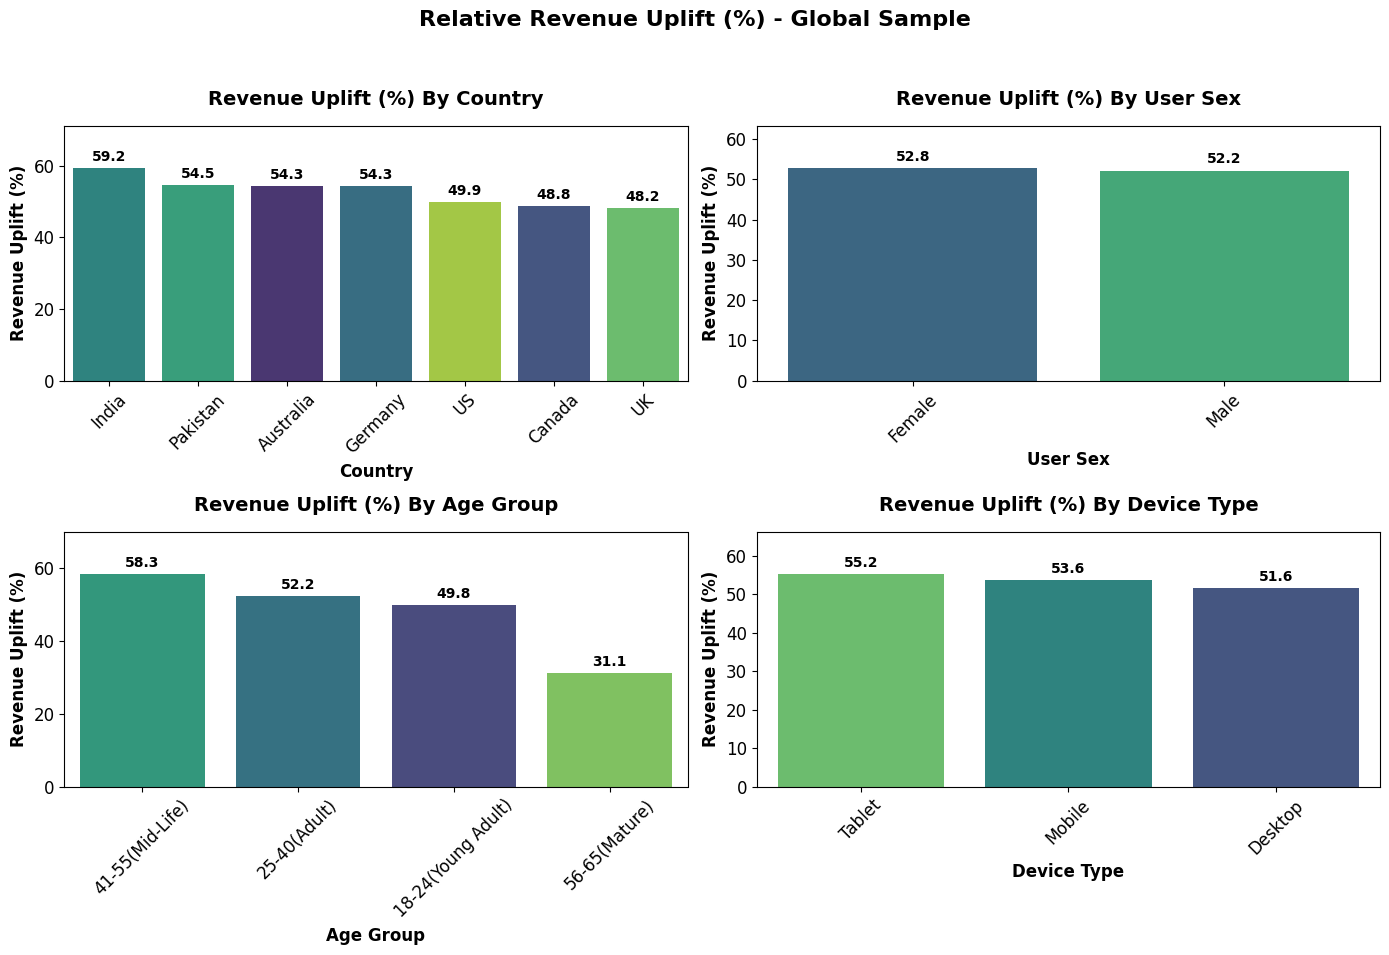

In [7]:
# 1. Define your "Manifest" as a List of Tuples
# Structure: (dataframe, column_name, x_axis_label, subplot_title)
configs = [
    (geo_results_df, 'location', 'Country', 'By Country'),
    (sex_results_df, 'sex', 'User Sex', 'By User Sex'),
    (age_results_df, 'age_group', 'Age Group', 'By Age Group'),
    (device_results_df, 'device_type', 'Device Type', 'By Device Type')
]

# 2. Setup the figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten() 
fig.suptitle('Relative Revenue Uplift (%) - Global Sample', fontsize=16, weight='bold')

# 3. The Loop
for ax, (df, col, label, title) in zip(axes, configs):

    # 1. Ensure the DataFrame is flattened
    # If 'col' is an index, this moves it back to being a column
    df_fixed = df.reset_index() if col not in df.columns else df
    plot_data = df_fixed
    
    
    if not plot_data.empty:
        # Sorting
        sort_order = plot_data.sort_values('revenue_uplift_percent', ascending=False)[col]
                
        # Call your custom barplot function
        mybarplot(
            plot_data, 
            x=col, 
            y='revenue_uplift_percent', 
            hue=col, 
            order=sort_order, 
            ax=ax, 
            title=f'Revenue Uplift (%) {title}', 
            x_label=label, 
            y_label='Revenue Uplift (%)',
            palette='viridis', 
            errorbar=None, 
            legend=False
        )
    # else:
    #     # This handles segments where no group reached p < 0.05
    #     ax.set_title(f"No Significant Results {title}")
    #     ax.text(0.5, 0.5, 'N/A', ha='center', va='center', fontsize=14, color='gray')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig(plots_dir+'global_revenue_uplift.png')
plt.show()

### Observations/Conclusions

* The results show global success of B-Version across all markets and major user sections.
* Based on this results, we can **recommend immediate global rollout of website's B-Version**.

# 3) ROI Analysis: Scaling Efficiency Vs. Volume

* I now compare the percentage revenue uplift to the absolute dollar lift between countries to gauge the market value of possible investments.

In [8]:
print('Incremental revenue ($) Vs revenre uplift (%), sorted by incremental revenue')
geo_results_df[['location','incremental_revenue','revenue_uplift_percent']].sort_values('incremental_revenue', ascending=False)


Incremental revenue ($) Vs revenre uplift (%), sorted by incremental revenue


,location,incremental_revenue,revenue_uplift_percent
6,US,96750.41,49.922073
3,India,74488.80,59.246119
5,UK,47125.59,48.232650
4,Pakistan,34785.54,54.503287
2,Germany,33915.85,54.281957
1,Canada,31840.96,48.769772
0,Australia,17328.53,54.337593


### Observations/Conclusions

* The results show that while the US generates the highest absolute dollar lift, it is probably not the most efficient market for new capital investment.
* In order to fully gain investment efficiency I use the data on the Cost Per Incremental Conversion (CPIC) per country, provided by the marketing department.

In [9]:
# Create the normilized CPIC and CPIC tier columns from known data

# create the location - normalized CPIC map:

location_CPIC_map = {
    'US': 1,
    'UK': 0.95,
    'Germany': 0.90,
    'Australia':0.80,
    'Canada': 0.75,
    'India':0.15,
    'Pakistan':0.12
}

# create the location - CPIC_tier map:

location_CPIC_tier_map = {
    'US': 'High_Cost',
    'UK': 'High_Cost',
    'Germany': 'High_Cost',
    'Australia':'Mid_Cost',
    'Canada': 'Mid_Cost',
    'India': 'Low_Cost',
    'Pakistan':'Low_Cost'
}

# create normalized CPIC column
geo_results_df['CPIC_norm'] = geo_results_df['location'].map(location_CPIC_map)

# create CPIC tier column
geo_results_df['CPIC_Tier'] = geo_results_df['location'].map(location_CPIC_tier_map)

* I combine the CIPC data with the revenue uplift and introduce the Strategic Investment Priority (SIP) score.
  
$$\rm{SIP} = \frac{\rm{Revenue\ uplift}}{\rm{normalized\ CPIC}}$$

* The SIP identifies markets where a \$1 investment produces the most significant relative growth.
* Double SIP means that the same \$1 will produce double ROI.

In [10]:
# Calculate SIP
geo_results_df['SIP']=geo_results_df['revenue_uplift_percent']/geo_results_df['CPIC_norm']

* Let's see the countries classifications by ROI

In [11]:
print('Incremental revenue ($) Vs revenre uplift (%) Vs SIP, sorted by SIP')
geo_results_df[['location','incremental_revenue','revenue_uplift_percent', 'SIP']].sort_values('SIP', ascending=False)

Incremental revenue ($) Vs revenre uplift (%) Vs SIP, sorted by SIP


,location,incremental_revenue,revenue_uplift_percent,SIP
4,Pakistan,34785.54,54.503287,454.194056
3,India,74488.80,59.246119,394.974124
0,Australia,17328.53,54.337593,67.921991
1,Canada,31840.96,48.769772,65.026363
2,Germany,33915.85,54.281957,60.313286
5,UK,47125.59,48.232650,50.771210
6,US,96750.41,49.922073,49.922073


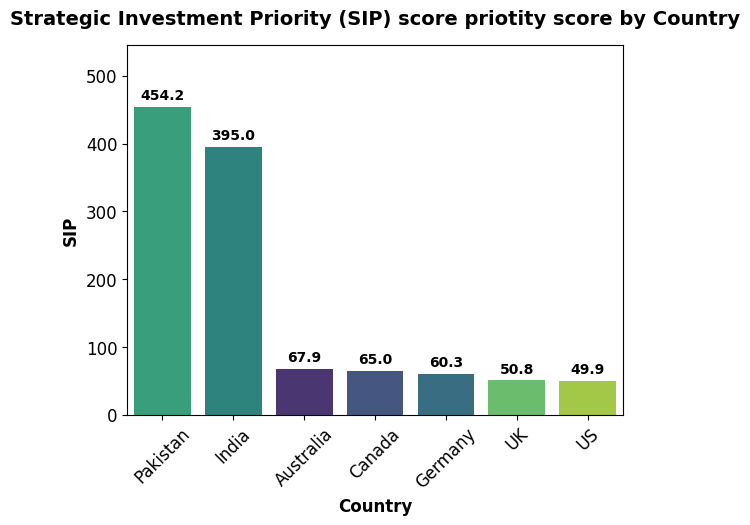

In [12]:
# Also Visualize the SIP by Country

plot_data=geo_results_df
x='location'
y='SIP'
hue='location'
x_label='Country'
y_label='SIP'
title='Strategic Investment Priority (SIP) score priotity score by Country'
order=plot_data.sort_values('SIP', ascending=False).location

mybarplot(plot_data, x, y, hue, order, ax=None, title=title, 
              x_label=x_label, y_label=y_label, palette='viridis', 
              errorbar=None, legend=False)

plt.savefig(plots_dir+'SIP_by_country.png')
plt.show()


### Observations/Conclusions

* Pakistan and India deliver an ROI **7–9x higher** than the US (and **>5x higher** than any other country) per dollar invested.
* **I recommend prioritizing marketing budgets toward these high-efficiency markets to maximize the conversion rate per unit of cost.**

# 4) Location ROI Analysis: Segment Opportunity Map

* For efficient rollout in a given country, I use 4D micro-segmentation to map user profiles (Sex + Age + Device) based on baseline scale vs. performance efficiency, with user segment size (bubble size) and incremental revenue information (bubble color).
* 4 quadrants are determined by the median revenue uplift (%) and median revenue ($) values.
* Only data from fully validated users (excluded cases where sex is unspecified).
* Only groups where we have statistical confidence on the revenue change with the new website design.
* I show the analysis for the highest priority market, Pakistan. This can be repeated for any country.


In [13]:
# Results by country
Pakistan_data_df = data_df[data_df['location']=='Pakistan']
profile_results_Pakistan_df = analyze_ab_segments(Pakistan_data_df, ['user_profile'])
profile_results_Pakistan_df = profile_results_Pakistan_df[(profile_results_Pakistan_df['P_Value']<0.05)] #filter to remove statistically insignificant results (p>0.05)

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


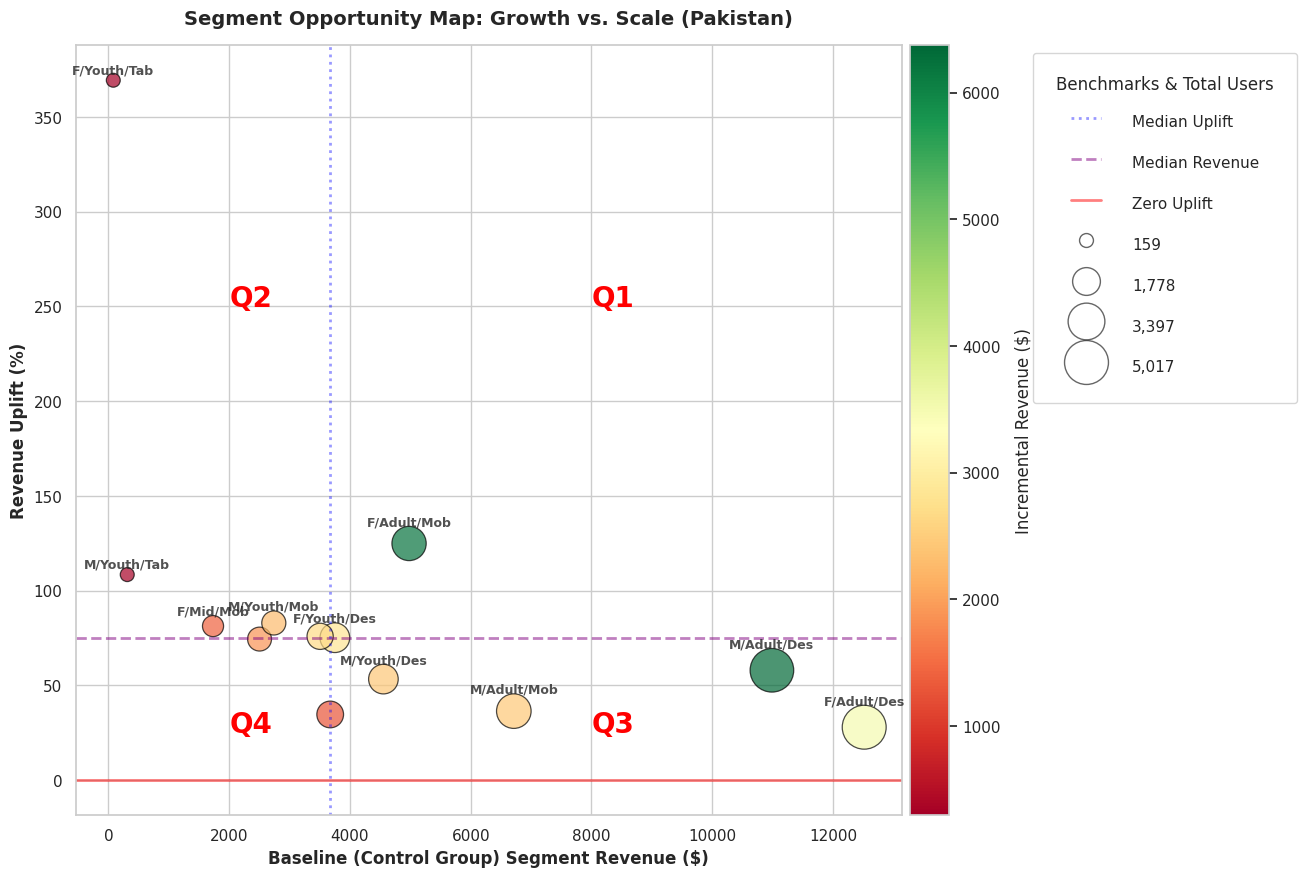

In [14]:
# Execute
# df=profile_results_Pakistan_df.reset_index()
plot = plot_segment_opportunity_map(profile_results_Pakistan_df)
# # plt.savefig('path.png')
plt.show()

### Targeted Recommendations



1. **Q1: High-baseline revenue with high uplift** (female, adult mobile users). Action: Prioritize aggressive marketing for increasing purchases and loyalty programs for retention. Focus on higher Volume/incremental revenue groups to maximize immediate total revenue impact.
2. **Q2: Low-baseline revenue groups with exceptional response rates** (eg female and male, young adults tablet users). Action: Targeted promotions to acquire more users of these specific profiles.
3. **Q3: High-baseline revenue segments with below-average response** (eg female and male adult desktop users). Action: Monitor for ‘UI Saturation’. Segments are stable but less responsive to design changes. Targeted promotions to increase conversion as this will give high additional revenue - focus on higher Volume/incremental revenue groups (male, adult desktop users).
4. **Q4: Small-baseline revenue segments with low lift**. Not in priorities targeting at immediate revenue growth.
5. **More data requirements**: Eleven out of 24 user profiles showed non-significant response (p > 0.05). These segments are currently de-prioritized for marketing spend until a clear performance trend is established.

